<a href="https://colab.research.google.com/github/Aleksey-Gladkih/Test_Guide/blob/Secondary/LB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Подключение Pandas
import pandas as pd
import numpy as np

In [ ]:
# 3. Но затем сайт изменился, и нужную таблицу таким способом стало невозможно получить.
# Нужно использовать более сложный способ, основанный на анализе содержимого кода страницы и извлечении из него нужных данных.
import requests
from bs4 import BeautifulSoup

def create_url(date):
  url_begin = "https://so-ups.ru/functioning/ees/ees-indicators/ees-gen-consump-hour/?tx_mscdugraph_pi%5Bcontroller%5D=Graph&tx_mscdugraph_pi%5Baction%5D=fullview&tx_mscdugraph_pi%5BviewDate%5D="
  url_end = "&tx_mscdugraph_pi%5BviewKpo%5D=6100"
  return url_begin + date + url_end
# https://so-ups.ru/functioning/ees/ees-indicators/ees-gen-consump-hour/?tx_mscdugraph_pi%5Bcontroller%5D=Graph&tx_mscdugraph_pi%5Baction%5D=fullview&tx_mscdugraph_pi%5BviewDate%5D=&tx_mscdugraph_pi%5BviewKpo%5D=6100
def parse_consumption(date):
  url = create_url(date)
  soup = BeautifulSoup(requests.get(url).content, 'html.parser')
  full_txt = str(soup)
  text_list_datetime = full_txt[full_txt.find('data-datax=') + len('data-datax=') + 1 : full_txt.find('data-datay=') - 2].split(',')
  text_list_consumption = full_txt[full_txt.find('data-datay=') + len('data-datay=') + 1 : full_txt.find('data-datay1=') - 2].split(',')
  text_list_generation = full_txt[full_txt.find('data-datay1=') + len('data-datay1=') + 1 : full_txt.find('data-date=') - 2].split(',')
  df = pd.DataFrame([text_list_datetime, list(map(int, text_list_generation)), list(map(int, text_list_consumption))])
  return df.T

In [ ]:
# 4. Можно взять данные за несколько дней и "склеить" их в одну таблицу
df_power = parse_consumption('2022-05-25')
df_power = df_power.append(parse_consumption('2022-05-26'))
df_power = df_power.append(parse_consumption('2022-05-27'))
df_power

,0,1,2
0,2022-05-25 0:00,105928,106143
1,2022-05-25 1:00,103755,103920
2,2022-05-25 2:00,102894,102996
3,2022-05-25 3:00,102918,103157
4,2022-05-25 4:00,104052,103878
...,...,...,...
19,2022-05-27 19:00,117254,116214
20,2022-05-27 20:00,115232,114891
21,2022-05-27 21:00,116097,115509
22,2022-05-27 22:00,113847,113414


In [ ]:
# 5. Переименуем столбцы
df_power_2 = df_power.copy()

df_power_2.columns = ['Время', 'Генерация (МВт)', 'Потребление (МВт)']

# Установим время в качестве метки строки
df_power_2 = df_power_2.set_index('Время')

# Явно укажем, что данные - целые числа
df_power_2['Генерация (МВт)'] = df_power_2['Генерация (МВт)'].astype('int')
df_power_2['Потребление (МВт)'] = df_power_2['Потребление (МВт)'].astype('int')

# Определим разность генерации и потребления
df_power_2['Разность (МВт)'] = df_power_2['Генерация (МВт)'] - df_power_2['Потребление (МВт)'] 

df_power_2

,Генерация (МВт),Потребление (МВт),Разность (МВт)
Время,,,
2022-05-25 0:00,105928,106143,-215
2022-05-25 1:00,103755,103920,-165
2022-05-25 2:00,102894,102996,-102
2022-05-25 3:00,102918,103157,-239
2022-05-25 4:00,104052,103878,174
...,...,...,...
2022-05-27 19:00,117254,116214,1040
2022-05-27 20:00,115232,114891,341
2022-05-27 21:00,116097,115509,588


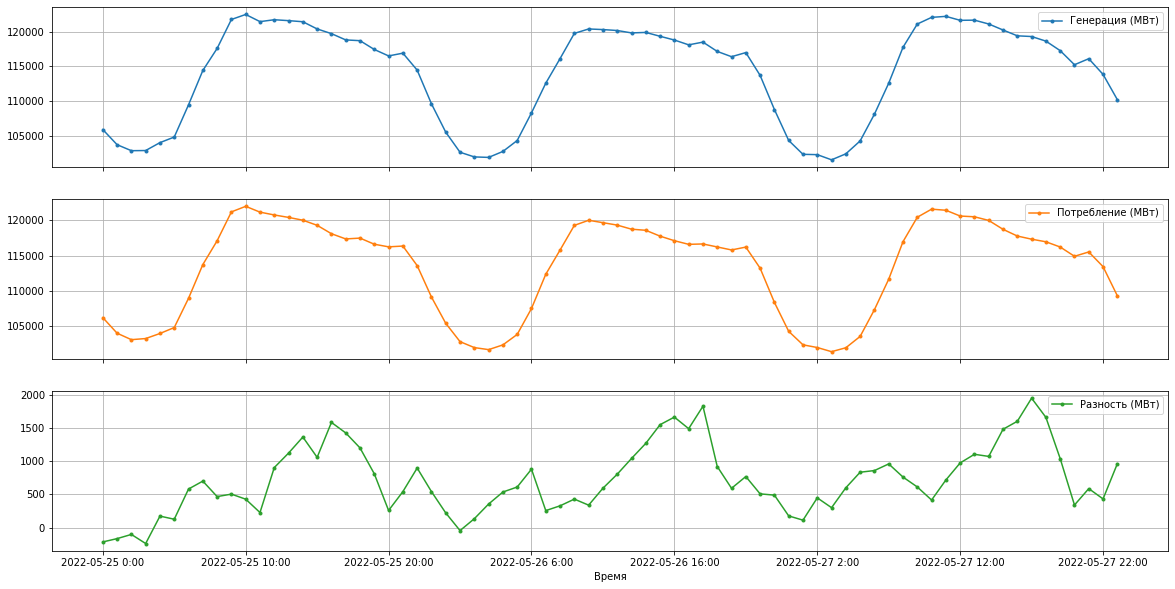

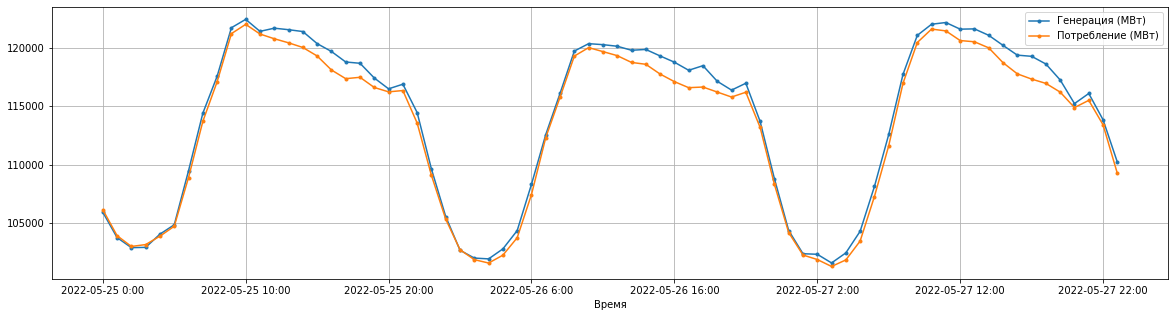

In [ ]:
# 6. Построение графиков
import matplotlib.pyplot as plt

axes = df_power_2.plot(marker='.', figsize=(20, 10), subplots = True)

for _ in axes:
  _.grid(True)

axes = df_power_2[df_power_2.columns[: -1]].plot(marker='.', figsize=(20, 5), subplots = False)
axes.grid(True)


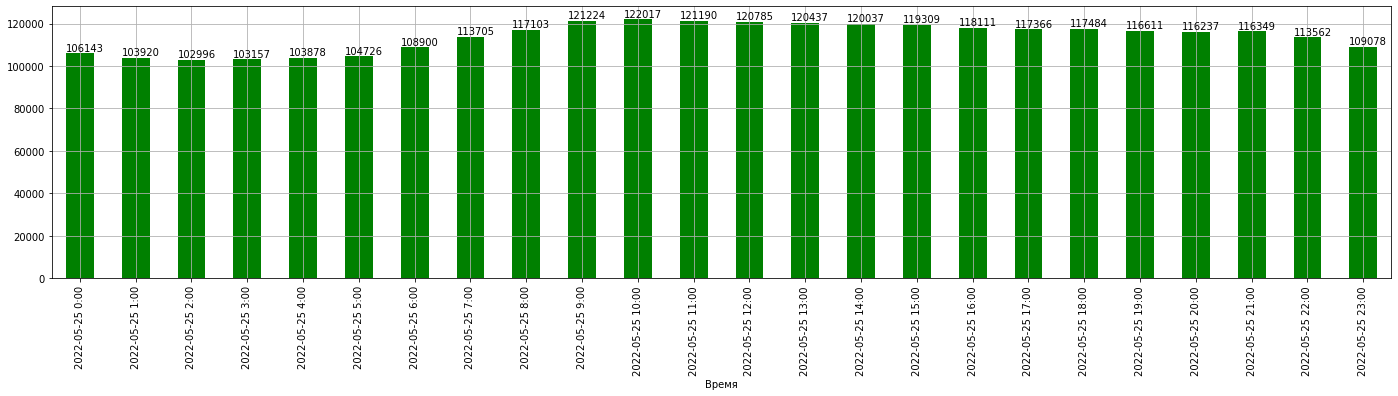

In [ ]:
# 7. Гистограмма
axes = df_power_2.iloc[ : 24, 1].plot(kind = 'bar', figsize=(24, 5), color = 'green')

# Добавление точных значений каждому столбцу. Решение нестандартное, найдено на Stackoverflow по запросу "pandas bar plot with values"
for p in axes.patches:
  axes.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))

axes.grid(True)

In [ ]:
# 8. Одна из важных статистических  метрик - корреляция.
df_power_2.corr()

,Генерация (МВт),Потребление (МВт),Разность (МВт)
Генерация (МВт),1.000000,0.998145,0.586919
Потребление (МВт),0.998145,1.000000,0.536543
Разность (МВт),0.586919,0.536543,1.000000


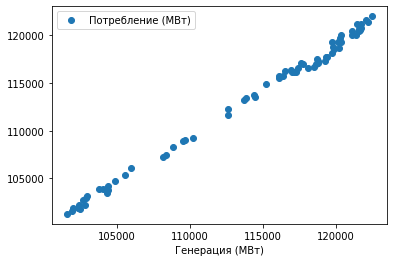

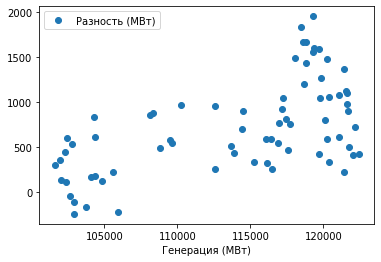

In [ ]:
# 9. Точечные графики, показывающие зависимости величин
df_power_2.plot(x = 'Генерация (МВт)', y = 'Потребление (МВт)', style='o')
df_power_2.plot(x = 'Генерация (МВт)', y = 'Разность (МВт)', style='o')

In [ ]:
# 10. Чтение данных из Excel-файла (https://minenergo.gov.ru/activity/statistic)
df_init = pd.read_excel('https://drive.google.com/uc?export=download&id=1IFULWv72kGpZRDRpqRskm5NIM6AOCFPR', header = None)
df_init.head()

,0,1
0,01.01.2013,103256.7
1,01.02.2013,91532.6
2,01.03.2013,97809.1
3,01.04.2013,85131.0
4,01.05.2013,79080.8


In [ ]:
# 3. Добавление строк
# Для добавления строк можно использовать функцию append. По сути здесь создается еще одна таблица тем же способом, что df_init. Затем добавляется к df_init
df_exted = df_init.append(pd.DataFrame({0: ['01.01.2020', '01.02.2020'], 1: ['79080.8', '93200.0']}), ignore_index = True)

df_exted.columns = ['Время', 'Генерация']

# первые строки таблицы можно вывести на экран в более простом виде, применив функцию print.
print(df_exted)
print()

# Получение списка имен столбцов
print('имена столбцов:', df_exted.columns.values)

         Время Генерация
0   01.01.2013  103256.7
1   01.02.2013   91532.6
2   01.03.2013   97809.1
3   01.04.2013   85131.0
4   01.05.2013   79080.8
..         ...       ...
81  01.10.2019   93200.0
82  01.11.2019   98900.0
83  01.12.2019  104400.0
84  01.01.2020   79080.8
85  01.02.2020   93200.0

[86 rows x 2 columns]

имена столбцов: ['Время' 'Генерация']


In [ ]:
# 12. Из таблицы, полученной в ячейке 10, видно, что у данных нет заголовка, а дата записана просто стройкой.
# Нужно дать столбцам имена и выделить из даты номер месяца и года.
# Для разделение строки на части используется функция split, которой нужно указать разделитель. В данном случае это точка.
df_date = df_init[0].str.split('.', expand = True) 
print(df_date.head())
print()

# Создание новой таблицы, изначально пустой.
df_gen = pd.DataFrame()

df_gen['Generation, mln MWt*h'] = df_init[1] / 1000 # перевод кВтч в МВтч
df_gen['Month_ID'] = df_date[1].astype(int) # указание, что этот столбец хранит уже не строки, а целые числа (int - integer)
df_gen['Year'] = df_date[2].astype(int) 

print(df_gen.head())

    0   1     2
0  01  01  2013
1  01  02  2013
2  01  03  2013
3  01  04  2013
4  01  05  2013

   Generation, mln MWt*h  Month_ID  Year
0               103.2567         1  2013
1                91.5326         2  2013
2                97.8091         3  2013
3                85.1310         4  2013
4                79.0808         5  2013


In [ ]:
# 5. Сортировка
df_gen = df_gen.sort_values(['Generation, mln MWt*h'], ascending = False)
print(df_gen)

# ascending задает сортировку по убыванию или возрастанию

    Generation, mln MWt*h  Month_ID  Year
71               107.5200        12  2018
47               106.0814        12  2016
72               105.7000         1  2019
83               104.4000        12  2019
36               104.2437         1  2016
..                    ...       ...   ...
18                76.2712         7  2014
6                 76.0954         7  2013
29                74.7375         6  2015
5                 74.4799         6  2013
17                73.9625         6  2014

[84 rows x 3 columns]


In [ ]:
# 6. Создание столбцов на основе вычислений.
# Чтобы случайно не испортить df_exted, будем работать с копией
df_gen_2 = df_gen.copy()

# Добавление столбца на основе формулы делается легко
df_gen_2['выработка_за_сутки'] = df_gen_2['Generation, mln MWt*h'] * 24 # 24 часа в сутках
print(df_gen_2)
# Легко применить расчеты, используя несколько столбцов сразу
df_gen_2['проверка_расчетов'] =  df_gen_2['выработка_за_сутки'] / df_gen_2['Generation, mln MWt*h'] == 24
print(df_gen_2)

    Generation, mln MWt*h  Month_ID  Year  выработка_за_сутки
71               107.5200        12  2018           2580.4800
47               106.0814        12  2016           2545.9536
72               105.7000         1  2019           2536.8000
83               104.4000        12  2019           2505.6000
36               104.2437         1  2016           2501.8488
..                    ...       ...   ...                 ...
18                76.2712         7  2014           1830.5088
6                 76.0954         7  2013           1826.2896
29                74.7375         6  2015           1793.7000
5                 74.4799         6  2013           1787.5176
17                73.9625         6  2014           1775.1000

[84 rows x 4 columns]
    Generation, mln MWt*h  Month_ID  Year  выработка_за_сутки  \
71               107.5200        12  2018           2580.4800   
47               106.0814        12  2016           2545.9536   
72               105.7000         1  2

In [ ]:
# 7.3. Через iloc по номерам строк и столбцов, номера идут с нуля
print('данные из первой строки и второго столбца')
print(df_gen_2.iloc[1 , 3])
print()
print('данные из всех строк кроме двух последних и из столбцов со второго по четвертый включительно')
print(df_gen_2.iloc[: -2, 2 : 5])
print()

# 7.1. Через имя столбца или столбцов
print('Выроботка')
print(df_gen_2['Generation, mln MWt*h'])
print()
print('Года')
print(df_gen_2.Year)
print()

данные из первой строки и второго столбца
2545.9536

данные из всех строк кроме двух последних и из столбцов со второго по четвертый включительно
    Year  выработка_за_сутки  проверка_расчетов
71  2018           2580.4800               True
47  2016           2545.9536               True
72  2019           2536.8000               True
83  2019           2505.6000              False
36  2016           2501.8488               True
..   ...                 ...                ...
7   2013           1844.9280               True
41  2016           1836.0528               True
18  2014           1830.5088               True
6   2013           1826.2896               True
29  2015           1793.7000               True

[82 rows x 3 columns]

Выроботка
71    107.5200
47    106.0814
72    105.7000
83    104.4000
36    104.2437
        ...   
18     76.2712
6      76.0954
29     74.7375
5      74.4799
17     73.9625
Name: Generation, mln MWt*h, Length: 84, dtype: float64

Года
71    2018
47    

In [ ]:
# 9. Выборка данных по условию.
# Выбрать электростанции с мощностью выше 400 МВт
print(df_gen_2[df_gen_2['выработка_за_сутки'] > 2500.])
print()

    Generation, mln MWt*h  Month_ID  Year  выработка_за_сутки  \
71               107.5200        12  2018           2580.4800   
47               106.0814        12  2016           2545.9536   
72               105.7000         1  2019           2536.8000   
83               104.4000        12  2019           2505.6000   
36               104.2437         1  2016           2501.8488   
48               104.1785         1  2017           2500.2840   

    проверка_расчетов  
71               True  
47               True  
72               True  
83              False  
36               True  
48               True  



In [ ]:
# 10. Статистические расчеты по сгруппированным данным.
# Суммарная мощность по типам электростанций.
print(df_gen_2.groupby(['Year'])['выработка_за_сутки'].sum())
print()

# Максимальная мощность по типам электростанций.
print(df_gen_2.groupby(['Month_ID'])['выработка_за_сутки'].max())
print()

# Число электростанций по мощности выше 500 МВт и разделением по компаниям
print(df_gen_2.groupby(['Year', df_gen_2['выработка_за_сутки'] > 1500])['выработка_за_сутки'].count())
print()

Year
2013    25080.3720
2014    25138.7352
2015    25197.7176
2016    25724.2008
2017    25769.3736
2018    26185.8984
2019    26308.8000
Name: выработка_за_сутки, dtype: float64

Month_ID
1     2536.8000
2     2280.0000
3     2412.0000
4     2119.2000
5     2006.4000
6     1920.0000
7     1963.2000
8     1994.4000
9     2016.0000
10    2237.5968
11    2373.6000
12    2580.4800
Name: выработка_за_сутки, dtype: float64

Year  выработка_за_сутки
2013  True                  12
2014  True                  12
2015  True                  12
2016  True                  12
2017  True                  12
2018  True                  12
2019  True                  12
Name: выработка_за_сутки, dtype: int64



Year
2013    1045.0155
2014    1047.4473
2015    1049.9049
2016    1071.8417
2017    1073.7239
2018    1091.0791
2019    1096.2000
Name: Generation, mln MWt*h, dtype: float64




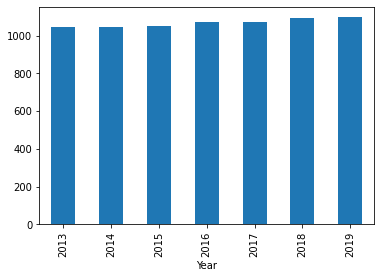

In [ ]:
# 13. Статистика суммарной генерации по годам.
year_stat = df_gen_2.groupby(['Year'])['Generation, mln MWt*h'].sum()

print(year_stat)
print()

year_stat.plot(kind = 'bar')
print()

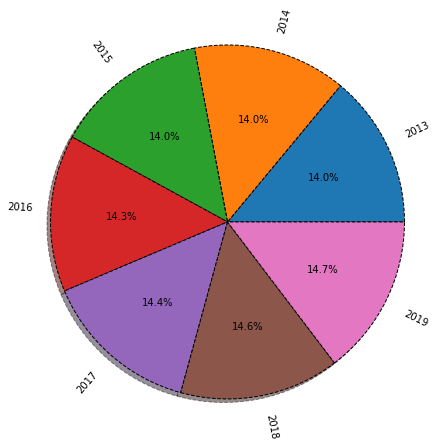

In [ ]:
df_oblast = df_gen_2.groupby('Year').sum()
figq, ax1 = plt.subplots(figsize = (7, 7))
ax1.pie(df_oblast['выработка_за_сутки'], labels = df_oblast.index, autopct= '%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':'k'},rotatelabels=True)
ax1.axis('equal')

plt.show()

In [ ]:
# 16. Подключение библиотек для интерактивного графика
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import numpy as np

output_notebook() # чтобы график показывался прямо в блокноте


# 17. Построение графиков помесячной выработки за каждый год 
p = figure(plot_width = 800, plot_height = 400)

# Список цветов по количеству лет.
colors = ['magenta', 'red', 'yellow', 'green', 'cyan', 'blue', 'black']

# Для каждого года свой график.
for year in range(2013, 2020):
  
  # Выбор из таблицы данных по выработке за нужный год. 
  values = df_gen_2[df_gen_2['Year'] == year]['Generation, mln MWt*h'].values 
  
  # Построение линий.
  p.line(np.arange(12), values, color = colors[year - 2013], legend_label = str(year), line_width = 3)

  # Построение маркеров.
  p.circle(np.arange(12), values, color = colors[year - 2013], alpha=0.5, size = 8)


show(p)